In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

from confidence_interval import calculate_confidence_interval, compare_model_accuracies

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

samples_per_run: 49
Model: Simple1d, Target Feature: endianness, Mean Accuracy: 0.7551, 95% CI: (0.6768, 0.8334)
samples_per_run: 49
Model: Simple1dEmbedding, Target Feature: endianness, Mean Accuracy: 0.7918, 95% CI: (0.6702, 0.9134)
samples_per_run: 49
Model: Simple2d, Target Feature: endianness, Mean Accuracy: 0.7633, 95% CI: (0.6826, 0.8439)
samples_per_run: 49
Model: Simple2dEmbedding, Target Feature: endianness, Mean Accuracy: 0.8041, 95% CI: (0.7147, 0.8935)
samples_per_run: 49
Model: ResNet50, Target Feature: endianness, Mean Accuracy: 0.7184, 95% CI: (0.6303, 0.8064)
samples_per_run: 49
Model: ResNet50Embedding, Target Feature: endianness, Mean Accuracy: 0.8000, 95% CI: (0.7160, 0.8840)
samples_per_run: 46
Model: Simple1d, Target Feature: instructionwidth_type, Mean Accuracy: 0.5118, 95% CI: (0.4122, 0.6113)
samples_per_run: 46
Model: Simple1dEmbedding, Target Feature: instructionwidth_type, Mean Accuracy: 0.5618, 95% CI: (0.4588, 0.6648)
samples_per_run: 46
Model: Simple2d, T

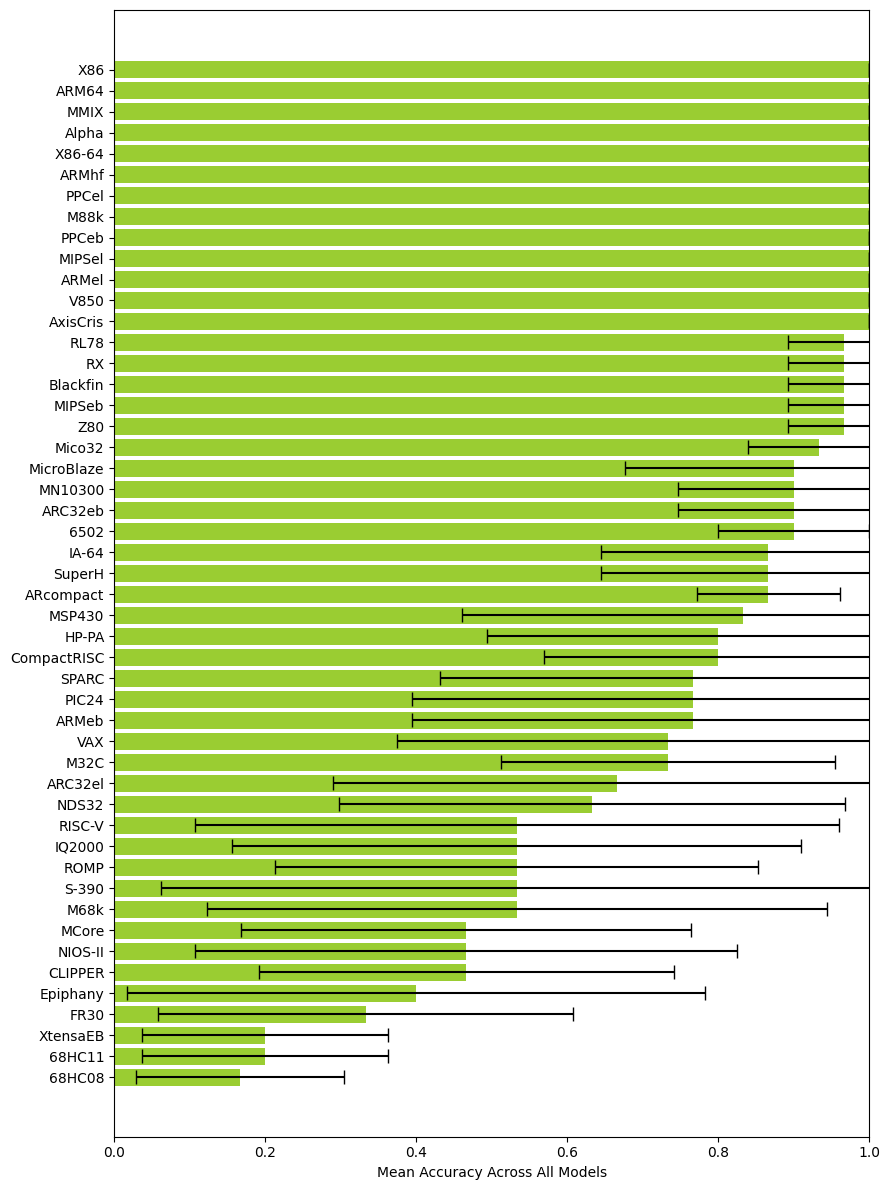

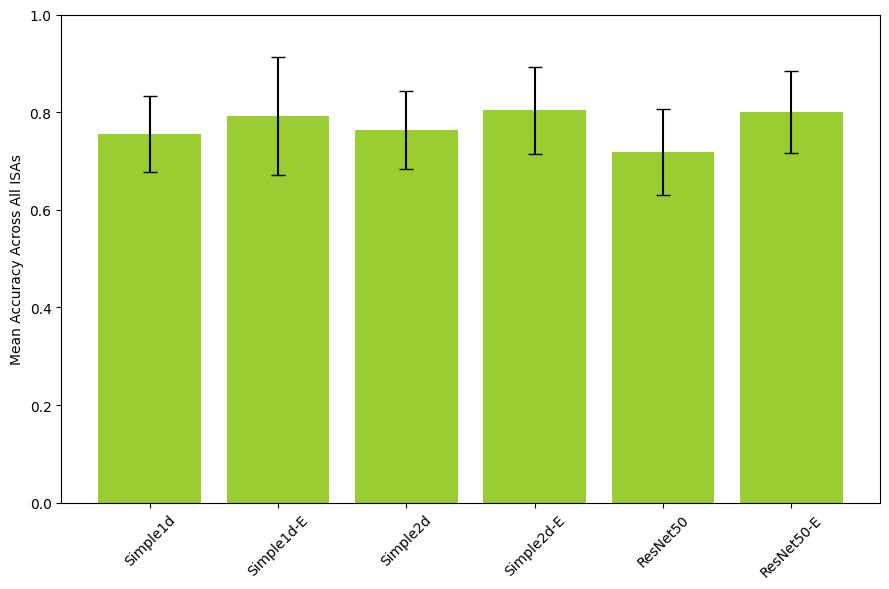

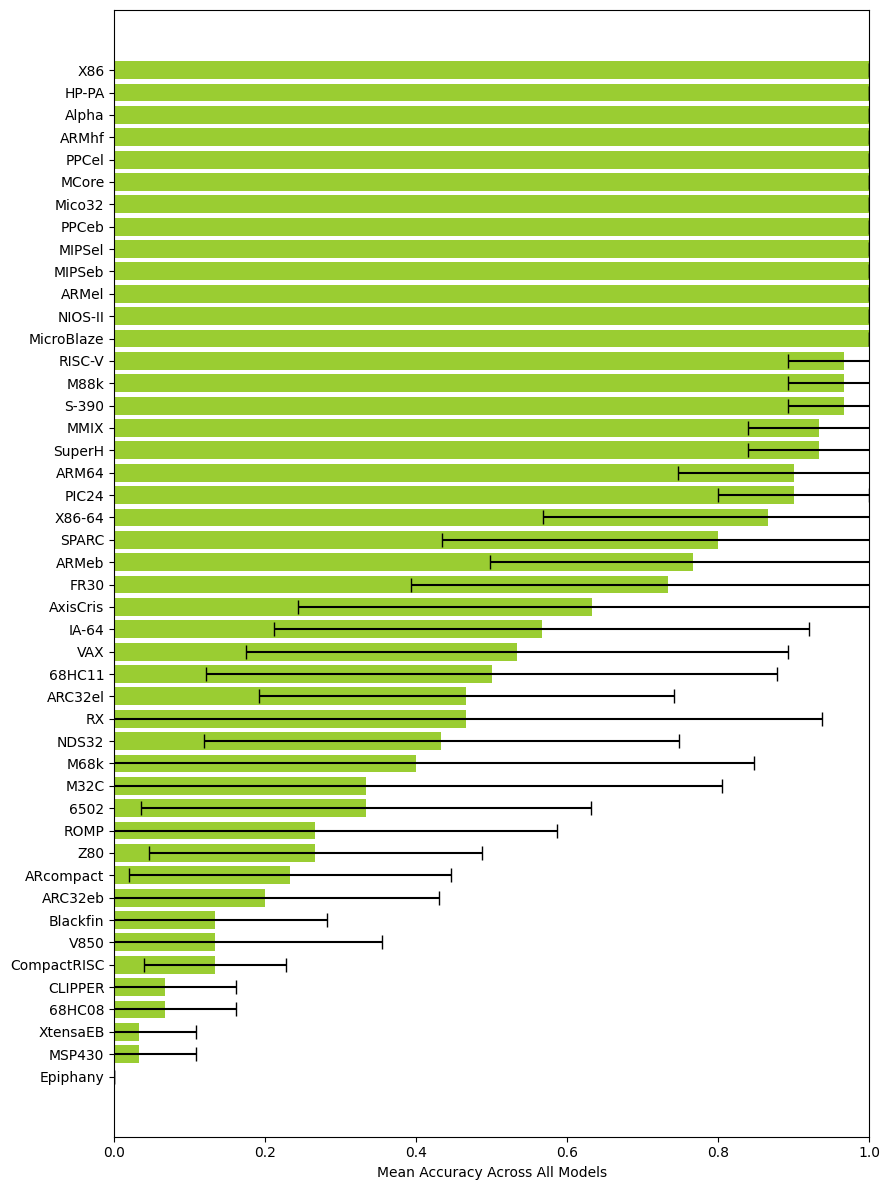

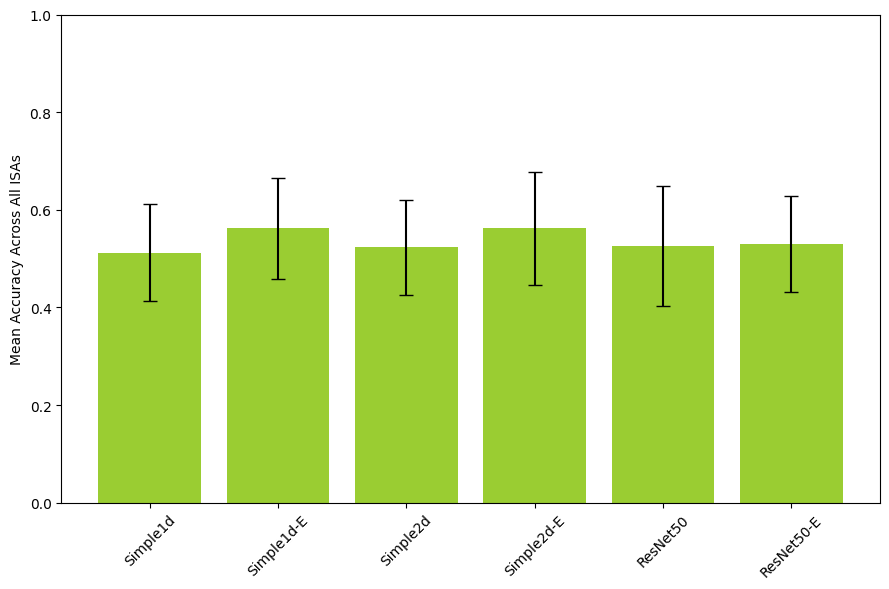

In [ ]:
# Specify the directory containing the CSV files
directory = "./input/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "CpuRec-*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    model_results = {}
    arch_model_results = {}
    all_architectures = set()

    # Find all architecture columns
    arch_columns = [
        col
        for col in df_all.columns
        if col.startswith("test_accuracy_") and col != "test_accuracy"
    ]
    architectures = [col.replace("test_accuracy_", "") for col in arch_columns]
    all_architectures.update(architectures)

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["validator.name"] == "train_test_separate_datasets")
            & (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        # Calculate the sum of all instance_count_* columns for each row
        samples_count_cols = [
            col for col in df.columns if col.startswith("instance_count_")
        ]
        df["total_samples_count"] = df[samples_count_cols].sum(axis=1).astype(int)

        # Ensure all rows have the same total instance count
        assert (
            df["total_samples_count"] == df["total_samples_count"].iloc[0]
        ).all(), "Not all rows have the same samples count."

        samples_per_run = int(df["total_samples_count"].iloc[0])

        model_mean, model_conf_95, _, _ = calculate_confidence_interval(
            accuracies=df["test_accuracy"], n_samples=samples_per_run, confidence=0.95
        )

        model_results[model_name] = (model_mean, model_conf_95)

        # Collect per-architecture results
        for arch_col in arch_columns:
            arch = arch_col.replace("test_accuracy_", "")
            if arch not in arch_model_results:
                arch_model_results[arch] = {}

            arch_mean = df[arch_col].mean()
            arch_std = df[arch_col].std()

            if not math.isnan(arch_mean):
                arch_model_results[arch][model_name] = (arch_mean, arch_std)

    # Calculate mean accuracy across models for each architecture
    arch_means = {}
    for arch in all_architectures:
        values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                values.append(arch_model_results[arch][model][0])
        if values:  # Only calculate if we have values
            arch_means[arch] = np.mean(values)

    # Sort architectures by mean accuracy (ascending)
    sorted_architectures = sorted(
        arch_means.keys(), key=lambda x: arch_means[x], reverse=False
    )

    # Create horizontal bar chart aggregated by architecture
    plt.figure(figsize=(9, 12))
    arch_means_list = []
    arch_stds_list = []

    for arch in sorted_architectures:
        arch_values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                arch_values.append(arch_model_results[arch][model][0])
        if arch_values:  # Only calculate if we have values
            arch_means_list.append(np.mean(arch_values))
            arch_stds_list.append(np.std(arch_values))

    bars = plt.barh(
        range(len(sorted_architectures)),
        arch_means_list,
        xerr=arch_stds_list,
        capsize=5,
        color="yellowgreen",
    )
    plt.yticks(range(len(sorted_architectures)), sorted_architectures)
    plt.xlabel("Mean Accuracy Across All Models")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig(f"output/cpurec-{target_feature.replace('_', '').lower()}-by-isa.png")

    # Create bar chart aggregated by model
    plt.figure(figsize=(9, 6))
    model_means = []
    model_stds = []

    for model in model_names:
        mean, std = model_results[model]
        model_means.append(mean)
        model_stds.append(std)

    xticks = [model.replace("Embedding", "-E") for model in model_names]

    bars = plt.bar(
        range(len(model_names)),
        model_means,
        yerr=model_stds,
        capsize=5,
        color="yellowgreen",
    )
    plt.xticks(range(len(model_names)), xticks, rotation=45)
    plt.ylabel("Mean Accuracy Across All ISAs")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"output/cpurec-{target_feature.replace('_', '').lower()}-by-model.png")

In [ ]:
# Create a combined results table per architecture
for target_feature in target_features:
    model_results = {}
    arch_model_results = {}
    all_architectures = set()

    # Find all architecture columns
    arch_columns = [
        col
        for col in df_all.columns
        if col.startswith("test_accuracy_") and col != "test_accuracy"
    ]
    architectures = [col.replace("test_accuracy_", "") for col in arch_columns]
    all_architectures.update(architectures)

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["validator.name"] == "train_test_separate_datasets")
            & (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        # Calculate the sum of all instance_count_* columns for each row
        samples_count_cols = [
            col for col in df.columns if col.startswith("instance_count_")
        ]
        df["total_samples_count"] = df[samples_count_cols].sum(axis=1).astype(int)

        # Ensure all rows have the same total instance count
        assert (
            df["total_samples_count"] == df["total_samples_count"].iloc[0]
        ).all(), "Not all rows have the same samples count."

        samples_per_run = int(df["total_samples_count"].iloc[0])

        model_mean, model_conf_95, _, _ = calculate_confidence_interval(
            accuracies=df["test_accuracy"], n_samples=samples_per_run, confidence=0.95
        )

        model_results[model_name] = (model_mean, model_conf_95)

        # Collect per-architecture results
        for arch_col in arch_columns:
            arch = arch_col.replace("test_accuracy_", "")
            if arch not in arch_model_results:
                arch_model_results[arch] = {}

            arch_mean = df[arch_col].mean()
            arch_std = df[arch_col].std()

            if not math.isnan(arch_mean):
                arch_model_results[arch][model_name] = (arch_mean, arch_std)

    # Calculate mean accuracy across models for each architecture
    arch_means = {}
    for arch in all_architectures:
        values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                values.append(arch_model_results[arch][model][0])
        if values:  # Only calculate if we have values
            arch_means[arch] = np.mean(values)

    # Sort architectures by mean accuracy (ascending)
    sorted_architectures = sorted(
        arch_means.keys(), key=lambda x: arch_means[x], reverse=False
    )

    # Create the combined table
    table_string = "| Architecture |"
    for model in model_names:
        table_string += f" {model} |"
    table_string += "\n| ------------ |"
    table_string += " ------------: |" * len(model_names)

    # Add rows for each architecture
    for arch in sorted_architectures:
        for i, model in enumerate(model_names):
            if arch in arch_model_results and model in arch_model_results[arch]:
                mean, std = arch_model_results[arch][model]

                if math.isnan(mean):
                    continue

                if i == 0:
                    table_string += "\n"
                    table_string += f"| {arch} |"

                table_string += f" {int(round(mean * 5))}/5 |"
            else:
                table_string += " - |"

    # Add overall row
    table_string += "\n"
    table_string += "| **Overall** |"
    for model in model_names:
        mean, conf_95 = model_results[model]
        table_string += f" **{mean:.3f}±{conf_95:.3f}** |"
    table_string += "\n"

    # Save the table
    filename = (
        f"output/cpurec-{target_feature.replace('_', '').lower()}-combined-results.md"
    )
    with open(filename, "w") as f:
        f.write(table_string)

    print(f"Results table for {target_feature}:")
    print(table_string)

Results table for endianness:
| Architecture | Simple1d | Simple1dEmbedding | Simple2d | Simple2dEmbedding | ResNet50 | ResNet50Embedding |
| ------------ | ------------: | ------------: | ------------: | ------------: | ------------: | ------------: |
| 68HC08 | 0/5 | 1/5 | 0/5 | 1/5 | 2/5 | 1/5 |
| 68HC11 | 0/5 | 2/5 | 2/5 | 1/5 | 1/5 | 0/5 |
| XtensaEB | 0/5 | 1/5 | 0/5 | 1/5 | 2/5 | 2/5 |
| FR30 | 0/5 | 1/5 | 4/5 | 1/5 | 3/5 | 1/5 |
| Epiphany | 4/5 | 0/5 | 5/5 | 0/5 | 2/5 | 1/5 |
| CLIPPER | 2/5 | 4/5 | 0/5 | 2/5 | 2/5 | 4/5 |
| NIOS-II | 4/5 | 1/5 | 5/5 | 1/5 | 0/5 | 3/5 |
| MCore | 1/5 | 4/5 | 3/5 | 0/5 | 4/5 | 2/5 |
| M68k | 0/5 | 5/5 | 1/5 | 5/5 | 1/5 | 4/5 |
| S-390 | 0/5 | 5/5 | 0/5 | 5/5 | 1/5 | 5/5 |
| ROMP | 2/5 | 5/5 | 0/5 | 4/5 | 3/5 | 2/5 |
| IQ2000 | 3/5 | 5/5 | 0/5 | 5/5 | 1/5 | 2/5 |
| RISC-V | 0/5 | 5/5 | 0/5 | 5/5 | 2/5 | 4/5 |
| NDS32 | 5/5 | 0/5 | 4/5 | 2/5 | 4/5 | 4/5 |
| ARC32el | 5/5 | 0/5 | 5/5 | 2/5 | 5/5 | 3/5 |
| M32C | 5/5 | 3/5 | 5/5 | 3/5 | 4/5 | 2/5 |